
# **Проект по анализу covid19 на территории РФ**

## План:



1.   Найти сервис, в котором свободно можно взять информацию о распространении covid19 на территории РФ

2.   Собрать информацию из этого сервиса в базу данных

3.   Удалить выбросы, если такие имеются

4.   Построить графики через matplotlib и посчитать некоторые метрики

5.   Построить основной описательный дашборд в Yandex Datalens



## Сбор информации и создание датасета

Для сбора информации о распространении COVID-19 я выбрал сайт, к которому буду обращаться через requests. В предоставленном на сайте JSON собрана информация о количестве подтверждённых случаев, смертности и количестве вылеченных случаев по большому количеству стран.

In [ ]:
# import всех нужных библиотек
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [ ]:
# используя библиотеку requests обращаемся к нашему сайту и получаем json с нужными данными

url = 'https://pomber.github.io/covid19/timeseries.json'
response = requests.get(url)
data = response.json()

# выводим данные по России
for i in data['Russia']:
  print(i)

{'date': '2020-1-22', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-23', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-24', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-25', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-26', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-27', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-28', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-29', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-30', 'confirmed': 0, 'deaths': 0, 'recovered': 0}
{'date': '2020-1-31', 'confirmed': 2, 'deaths': 0, 'recovered': 0}
{'date': '2020-2-1', 'confirmed': 2, 'deaths': 0, 'recovered': 0}
{'date': '2020-2-2', 'confirmed': 2, 'deaths': 0, 'recovered': 0}
{'date': '2020-2-3', 'confirmed': 2, 'deaths': 0, 'recovered': 0}
{'date': '2020-2-4', 'confirmed': 2, 'deaths': 0, 'recovered': 0}
{'date': '2020-2-5', 'confirmed': 2, 'deaths': 0, 'recovered': 0}


Как мы видим, данных достаточно для анализа, но я считаю, что они представлены несколько неудобно. Например, в поле 'confirmed' указаны данные не **за** этот день, а **на** данный день, что может вызвать определённые проблемы в анализе. Поэтому в датасет я буду записывать разницу между данными за текущий день и предыдущий.



In [ ]:
with open('main_csv.csv', mode='w') as file:
    file.write('date;confirmed;deaths;recovered')
    old_conf = 0
    old_deaths = 0
    old_rec = 0
    for i in data['Russia']:
        file.write(f'\n{i["date"]};{i["confirmed"] - old_conf};{i["deaths"] - old_deaths};{i["recovered"] - old_rec}')
        old_conf = i["confirmed"]
        old_deaths = i["deaths"]
        old_rec = i["recovered"]

## Проверка на выбросы

Теперь пришло время проверить наши данные на выбросы. Проверку я буду проводить с использованием интерквартильного размаха и выводить выбросы.

In [ ]:
# чтение датасета средствами pandas

df = pd.read_csv('main_csv.csv', delimiter=';')

In [ ]:
anomalies = {}

for column in ['confirmed', 'deaths', 'recovered']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound_iqr = Q1 - 3 * IQR
    upper_bound_iqr = Q3 + 3 * IQR

    anomalies[column] = df[column][df[column].apply(lambda x: x < lower_bound_iqr or x > upper_bound_iqr)].tolist()

for column, j in anomalies.items():
    if j == []:
        pass
    else:
        print(f'{column}: {j}')

confirmed: [88105, 97284, 112302, 120324, 123033, 124693, 141005, 154643, 166957, 175979, 178616, 170532, 164097, 181791, 195293, 202211, 201955, 195813, 178785, 165139, 177823, 178725, 178016, 176924, 168399, 149866, 132912, 135885, 131249, 121920, 121647, 114610, 105745, 96092, 96180, 91934, 88130, 85575, 78632]
recovered: [-5609682]


**Важный момент:** как видно, выбросы имеются в полях 'confirmed' и 'recovered', но здесь мы сталкиваемся с распространённой ситуацией, которая может вводить в заблуждение.

В поле 'recovered' всё понятно: это значение физически невозможно и его можно удалять. Однако с полем 'confirmed' всё не так просто. При медицинском, социальном анализе или анализе заболеваемости правило трёх сигм или интерквартильный размах используются для **обнаружения** странных значений, но это не гарантирует, что эти значения являются выбросами и что их нужно удалять. Здесь вступает в силу "логический" анализ.

Как я уже сказал, значения в поле 'recovered' просто физически невозможны, в отличие от значений в поле 'confirmed'. Давайте вычислим сумму выбросов в этом поле.

In [ ]:
print(sum(list(anomalies.items())[0][1]))

5568821


Получившееся значение далеко не превосходит население РФ и вполне возможно при сильном скачке динамики заражения, поэтому принимаем тот факт что **в поле confirmed выбросов нет.**

In [ ]:
df['recovered'] = df['recovered'].replace(-5609682, pd.NA)

df = df.dropna()


## Вводим новые поля и строим графики

Я хочу ввести поле, которое будет являться строкой в которой написано время года, возможно есть корреляция времени года от количества заражёный(сезонность). Это понадобится при построении дашборда.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df['season'] = df['date'].dt.month.apply(lambda x: (
    'Winter' if (x >= 1 and x <= 2) or x == 12
    else 'Spring' if x >= 3 and x <= 5
    else 'Summer' if x >= 6 and x <= 8
    else 'Autumn' if x >= 9 and x <= 11
    else None
))

df.to_csv('main_csv_season.csv', index=False) # сохраняю файл для послежущего импорта в Yandex Datalens

Теперь построим несколько базовых графиков по каждому полю

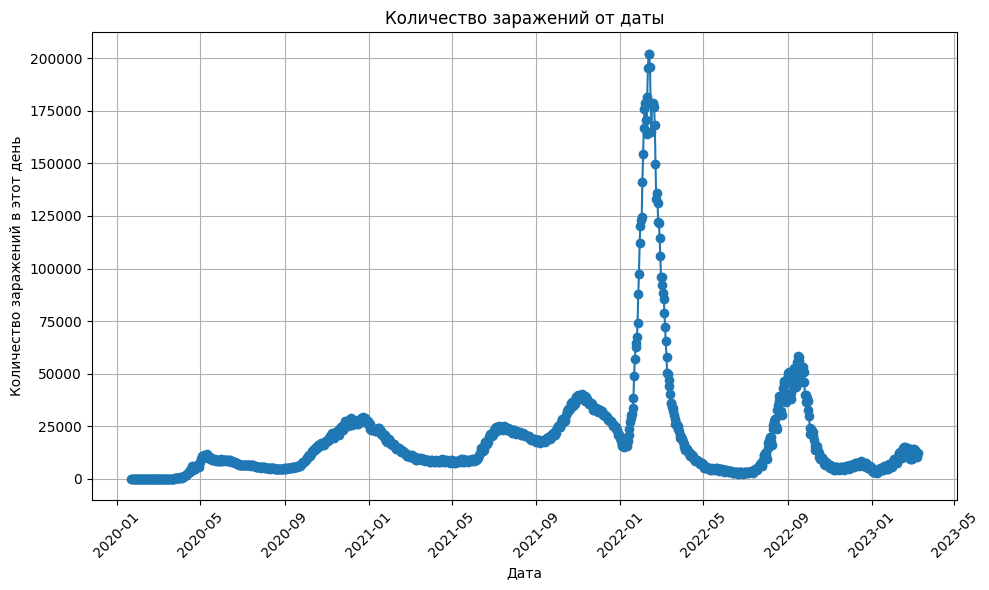

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['confirmed'], marker='o', linestyle='-')
plt.title('Количество заражений от даты')
plt.xlabel('Дата')
plt.ylabel('Количество заражений в этот день')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Как мы видим, самый пик динамики заражения пришёлся на январь и февраль 2022 года, также значительное повышение было в октябре того же года.***

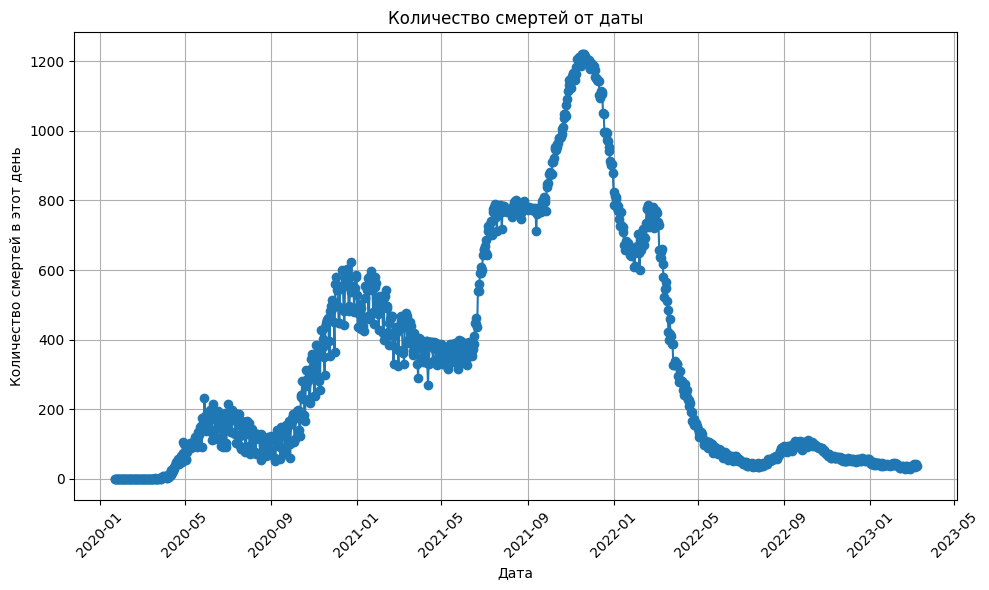

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['deaths'], marker='o', linestyle='-')
plt.title('Количество смертей от даты')
plt.xlabel('Дата')
plt.ylabel('Количество смертей в этот день')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***На этом графике пик находится также в январе - феврале 22 года. Из интерестного можно отметить что в октябре того же года далеко нет такого повышения динамики как на прошлом графике.***

Из этого можно сделать вывод, что это был не такой активный(летальный) штамм covid19, или что к тому времени научились наиболее качественно бороться с вирусом.

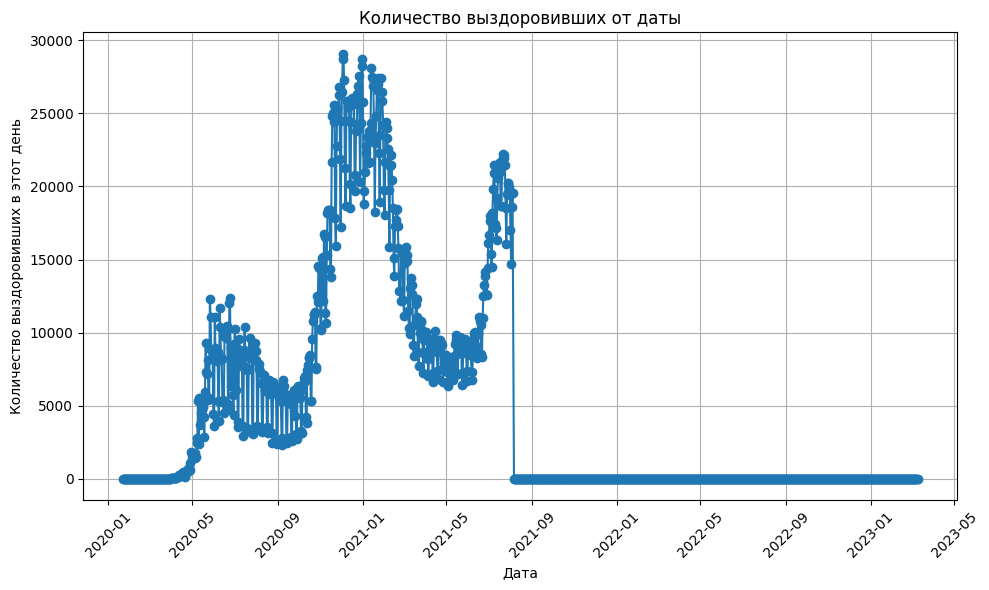

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['recovered'], marker='o', linestyle='-')
plt.title('Количество выздоровивших от даты')
plt.xlabel('Дата')
plt.ylabel('Количество выздоровивших в этот день')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Здесь мы видим печальную картину, так как после августа 21 года данные перестали собираться или были повреждены, поэтому анализу не поддаются.***

А теперь посчитаем несколько базовых метрик и одну очень даже интересную.

In [ ]:
print(f'Среднее количество заражений за день: {int(sum(df["confirmed"]) / len(df["confirmed"]))}')
print(f'Среднее количество смертей за день: {int(sum(df["deaths"]) / len(df["deaths"]))}')
print(f'Всего случаев заражения: {int(sum(df["confirmed"]))}')
print(f'Всего смертей: {int(sum(df["deaths"]))}')

Среднее количество заражений за день: 19311
Среднее количество смертей за день: 339
Всего случаев заражения: 22053294
Всего смертей: 387707


In [ ]:
date_first_death = df.loc[df['deaths'] >= 1, 'date'].min()
date_first_conf = df.loc[df['confirmed'] >= 1, 'date'].min()


print(f'Сколько прошло дней с первого заражённого до первой смерти: {date_first_death - date_first_conf}')

Сколько прошло дней с первого заражённого до первой смерти: 48 days 00:00:00


## ДАШБОРД

Всю работу по дашборду я выполняю в системе Yandex Datalens, сюда будут прикреплены несколько скриншотов дашборда, но настоятельно рекомендую перейти по ссылке и посмотреть лично. На дашборде имеются небольшие пояснения, возможность приближать графики и выбрать конкретный временой промежуток.

**ССЫЛКА НА ДАШБОРД:** https://datalens.yandex/i590tpe6bc825

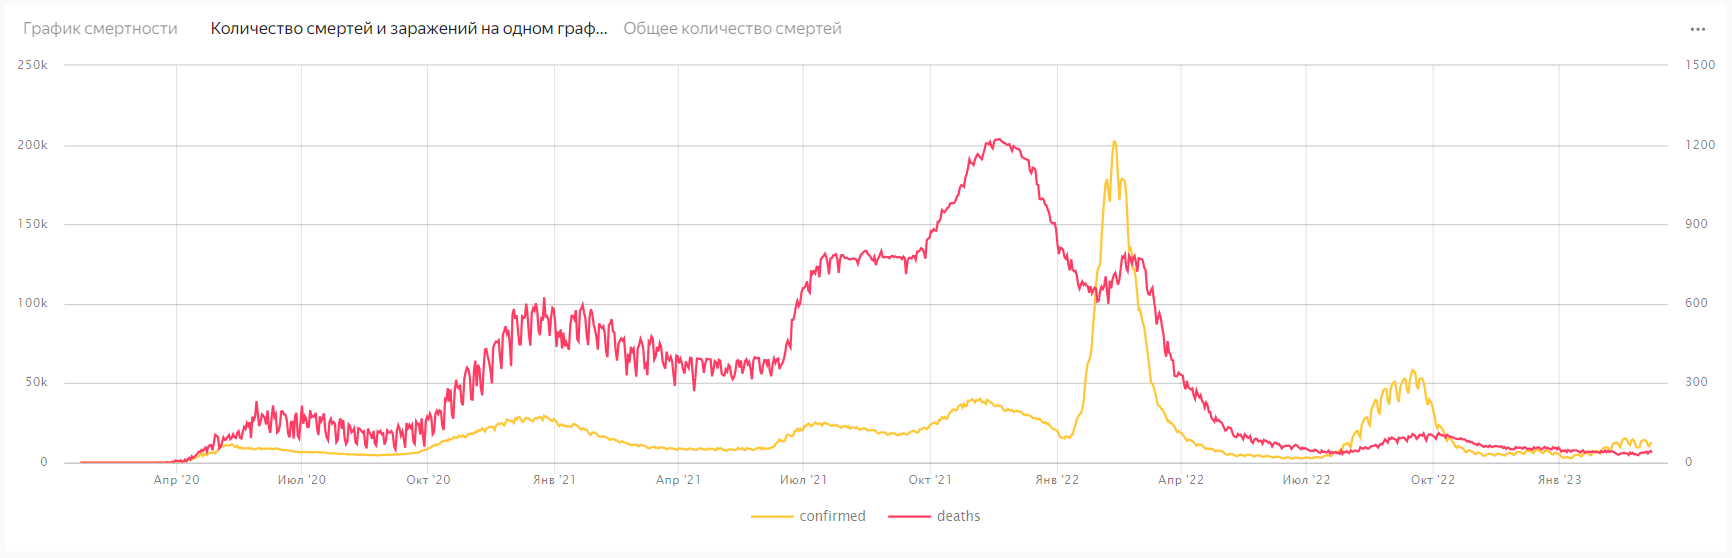

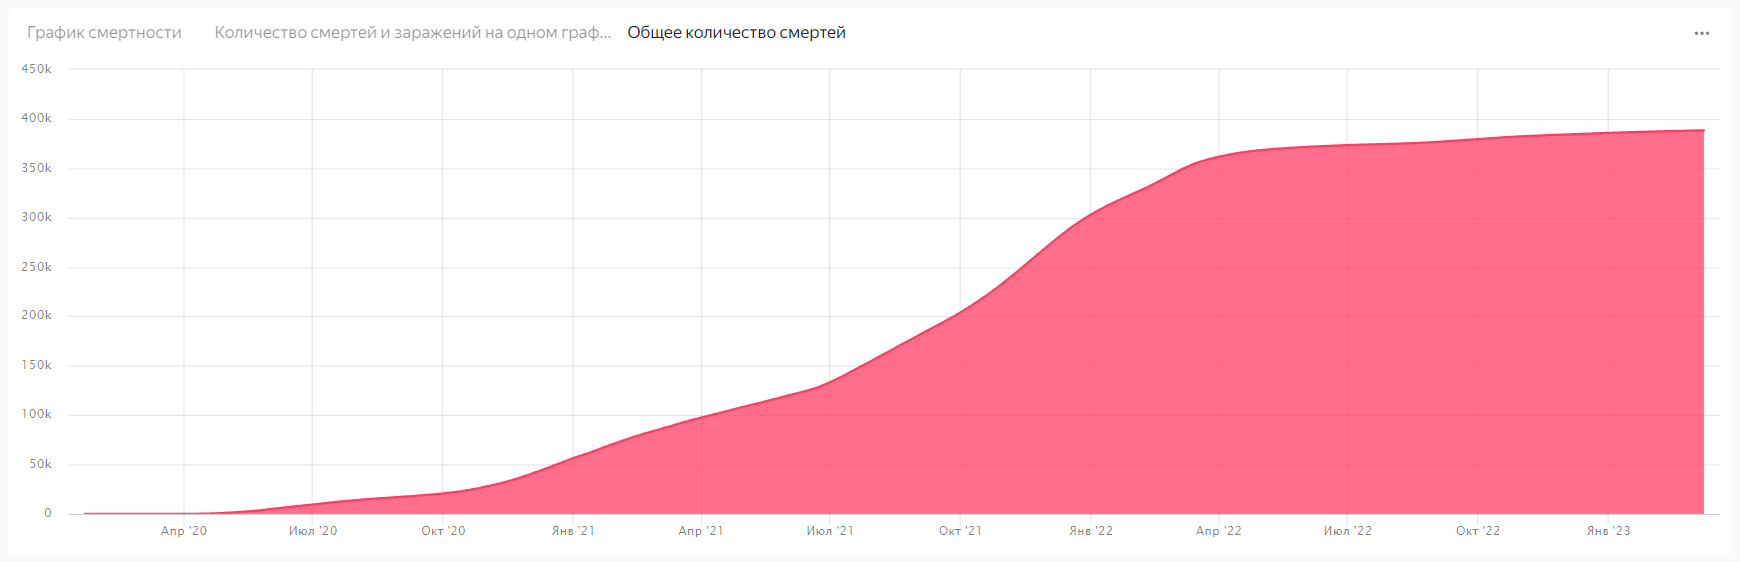

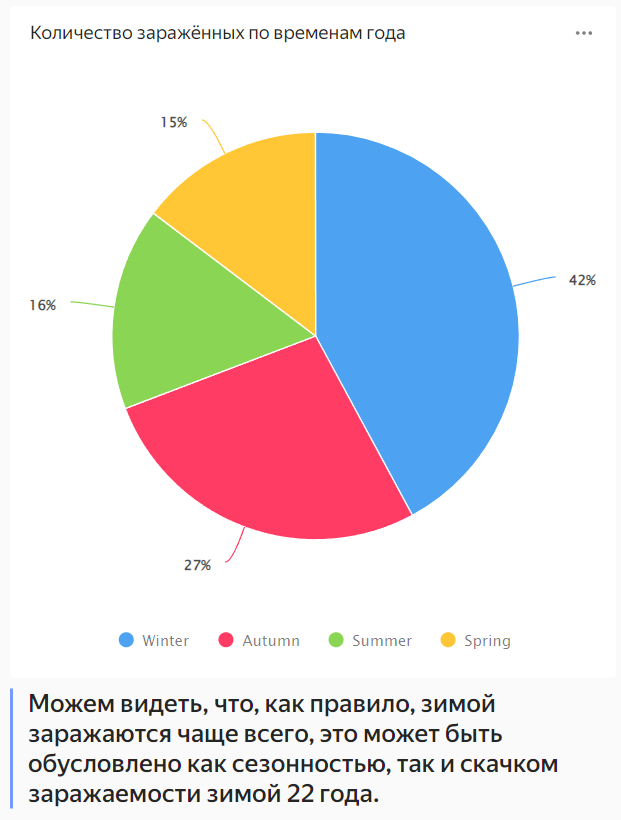